In [4]:
# np-pd-mpl
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Neural network packages
def import_nn_packages():
    import torch
    import torch.nn as nn 
    import torch.nn.functional as F
    import torch.utils.data
    import torch.optim
    import pytorch_lightning as pl 
    from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Built-in
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import time
import copy
import random
import pickle
from typing import List, Tuple, Dict, Any, Generator
import logging
import collections
logging.getLogger('lightning').setLevel(0)

def import_pl():
    !pip install pytorch-lightning --quiet
    # !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    # !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
    !pip install sdv --quiet

# sklearn
def import_sklearn_stuff():
    from sklearn import feature_selection
    import sklearn.preprocessing
    import sklearn.metrics
    from sklearn import model_selection
    from sklearn import decomposition
    from sklearn import linear_model
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cd "/content/gdrive/MyDrive/" && ls # Displays directories in MyDrive/
dir_path = os.path.join("/content/gdrive/MyDrive/Data", "COMS 6998 DS")
assert os.path.exists(dir_path) # Make sure the Drive is visible. 
sys.path.append(dir_path)


 ApTSi
'Colab Notebooks'
'Columbia Student Services Online - Grades and Registration Status.pdf'
 Data
 Education
'exam ud2127.pdf'
 Hello.txt
'Lab1 Divine Grade Sheet (2020).pdf'
 lab1.pdf
 Other
 Recordings
'School-Related Planning'
 SCIP
 temp
'Unique lab1.pdf'
 地位を申し込む


In [ ]:
!cd {dir_path} & ls

/bin/bash: line 0: cd: too many arguments
gdrive	sample_data


In [ ]:
data_path = os.path.join(dir_path, "parking_violations_2021.csv")
# df = df[df.groupby('Issue Date')['Issue Date'].transform('count') > 50]

data_generator: Generator = pd.read_csv(data_path, chunksize=int(7e6))
for idx, batch in enumerate(data_generator):
    df = batch
    break


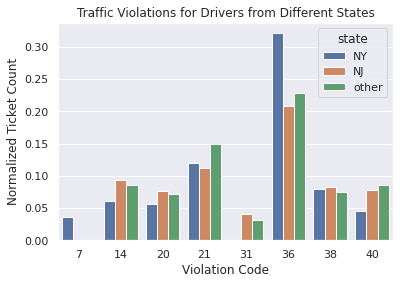

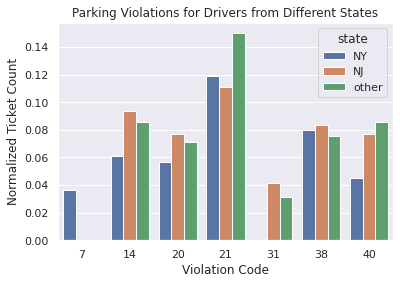

In [ ]:
def toy(df, k=7):
    df = df[['Violation Code', 'Registration State']].astype(
        {"Registration State": 'category'})
    # counts_by_state = df.groupby('Registration State')['Violation Code'].count()
    state = df['Registration State']
    categories = np.array(
        ['NY', 'NJ', 'other'])
    df['Registration State'] = pd.Categorical(
        df['Registration State'], categories=categories)

    groups = [df[state == 'NY'],
              df[state == 'NJ'], 
              df[(state != 'NY') & (state != 'NJ')]]
    groups = [group['Violation Code'] for group in groups]
    topk_vcs = [group.value_counts(normalize=True)[:k] for group in groups]
    
    ny_vcs, nj_vcs, other_vcs = topk_vcs
    def df_subset(value_counts, reg_state_name: str) -> pd.DataFrame:
        standardized_counts = value_counts.values, 
        registration_codes = value_counts.index.tolist()
        states = [reg_state_name] * k
        standardized_counts, codes, states = [np.array(s).reshape(-1,1) \
            for s in [standardized_counts, registration_codes, states]]
        boi = np.hstack([standardized_counts, codes, states])
        boi = pd.DataFrame(data=boi, 
                    columns = ['count', 'code', 'state'])
        return boi

    bois = [df_subset(value_counts=ny_vcs, reg_state_name='NY'), 
            df_subset(value_counts=nj_vcs, reg_state_name='NJ'),
            df_subset(value_counts=other_vcs, reg_state_name='other')]

    bois = pd.concat(bois)
    bois['count'] = bois['count'].astype(float)
    bois['code'] = bois['code'].astype(int)
    bois['state'] = bois['state'].astype(str)
    return bois

yeet = toy(df)

ax = sns.barplot(x="code", y="count", hue="state", data=yeet)
ax.set(xlabel='Violation Code', ylabel='Normalized Ticket Count', 
       title='Traffic Violations for Drivers from Different States')
plt.show()

ax = sns.barplot(x="code", y="count", hue="state", data=yeet[yeet.code != 36])
ax.set(xlabel='Violation Code', ylabel='Normalized Ticket Count', 
       title='Parking Violations for Drivers from Different States')
plt.show()

 ----
 

In [ ]:
def clean_dates(df: pd.DataFrame,
                threshold: int = 50, 
                start_date: str = '2020-01-01', 
                end_date: str = '2021-03-01') -> pd.DataFrame:
    """The dataset contains many ticket dates that are both in the future 
    and in the distant past. It's only supposed to include tickets from 2020 
    and 2021, so we can clean out the nonsensical dates.
    
    Args:
        df 
        threshold
        start_date
        end_date
    """
    # Remove dates with frequency below threshold.
    counts = df['Issue Date'].value_counts()
    freq_dates = list(counts.where(counts > threshold).dropna().index)
    is_freq_date = pd.Series([(d in freq_dates) for d in df['Issue Date']])
    issue_date = pd.to_datetime(df['Issue Date'].where(is_freq_date).dropna()) 
    # Remove dates that lie outside the specified window. 
    mask = (issue_date >= start_date) & (issue_date <= end_date)
    num_valid_dates_in_window =  issue_date.loc[mask].size
    num_dates = df.shape[0]

    pct_valid = round(number = (num_valid_dates_in_window / num_dates), 
                      ndigits = 5)
    print(num_valid_dates_in_window, num_dates)
    print(f"Percentage of data remaining: {pct_valid * 100} %")

    return None
    
# View shortcuts: Ctrl + M, H
# clean_dates(DATASET)

In [ ]:
import datetime

def get_time_of_day(df) -> np.ndarray:
    """Args: df (pd.DataFrame): The dataset.
    Returns: time_of_day (np.ndarray): Time of day in minutes 
        for each valid time."""
    hours, minutes = [], []
    for idx, t in enumerate(df['Violation Time'].dropna(inplace=False)):
        assert isinstance(t, (str, float))
        if isinstance(t, str) and len(t) == 5:
            try:
                hour, minute, ampm = int(t[:2]), int(t[2:-1]), t[-1]
            except: # Invalid time 
                continue
        elif isinstance(t, str) and len(t) == 4:
            try:
                hour, minute = int(t[:2]), int(t[2:])
            except:
                continue
        else:
            print(t, 'it me', 'yikes')

        # Translate to military time. 
        if hour == 12 and ampm == 'A':
            hour = 0
        elif hour < 12 and ampm == 'P':
            hour = hour + 12
        elif (hour < 12 and ampm == 'A') or (hour == 12 and ampm == 'P'):
            pass # Valid date, no processing needed
        elif (hour > 12 and hour < 24 and minute < 60): 
            pass # If the officer forgot to write AM/PM
        else:
            continue

        hours.append(hour)
        minutes.append(minute)

    hours = np.array(hours, dtype=int)
    minutes = np.array(minutes, dtype=int)
    time_of_day = hours * 60 + minutes 
    return time_of_day

time_of_day = get_time_of_day(df = df)

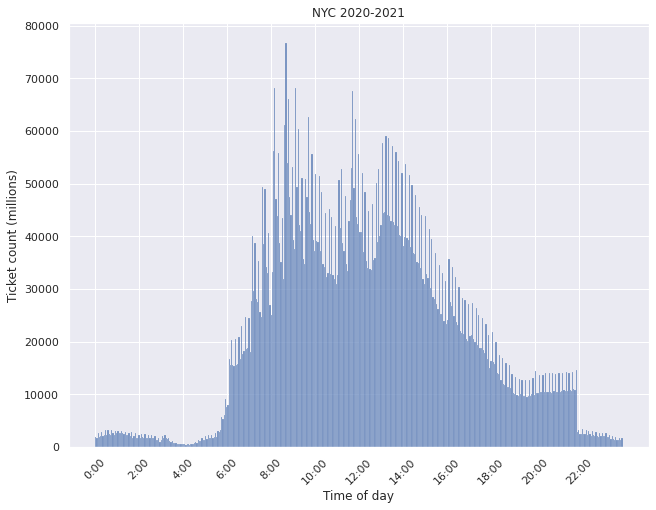

In [ ]:
def plot_time_of_day(tod: np.ndarray, scale = 1.3):
    """Args: tod (np.ndarray): Time of day in minutes."""
    figsize = np.array([8, 6]) * scale
    fig, ax = plt.subplots(figsize=figsize)

    hours = (tod / 60)
    # counts, bins = np.histogram(hours, bins=10)
    sns.histplot(hours)
    ax.set(xlabel = "Time of day", ylabel = "Ticket count (millions)", 
           title = "NYC 2020-2021")
    hours_in_day = [f"{h}:00" for h in np.arange(24)]
    plt.xticks(np.arange(12) * 2, hours_in_day[::2])
    plt.setp(ax.get_xticklabels(), rotation=45)
    # print(ax.get_xticks(), ax.get_xticklabels())
    plt.show()

plot_time_of_day(tod = time_of_day)

In [ ]:
def residency_status(df: pd.DataFrame):
    boi = df.head()
    itme = df.groupby('Violation Code')
    # itme = df['Violation Code'].value_counts()

    # boi = (df['Violation Code'] == 4).sum()
    return boi
    # itme.hist()
    # boi = itme.loc[itme > 10].size
    # itme.size
    # return boi  / itme.size

residency_status(df = DATASET[['Registration State', 'Violation County', 'Violation Code']])

,Registration State,Violation County,Violation Code
0,NY,Q,20
1,NY,Q,20
2,NY,Q,20
3,NY,Q,20
4,NY,Q,20


In [ ]:
df = DATASET[['Violation County', 'Violation Time']]
df.head()

,Violation County,Violation Time
0,Q,1259P
1,Q,0940A
2,Q,0940A
3,Q,0940A
4,Q,0940A


In [ ]:
df.columns

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

In [ ]:
df.describe()

,Summons Number,Violation Code,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Date First Observed,Law Section,Vehicle Year,Feet From Curb,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
count,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,5.861308e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,8.996631e+06,0.0,0.0,0.0
mean,7.061968e+09,3.351642e+01,2.010064e+04,1.695685e+04,1.685418e+04,2.241923e+07,5.624628e+01,3.664447e+01,3.756270e+01,2.494710e+05,1.656227e+05,6.722181e+02,1.591056e+03,9.789687e-02,NaN,NaN,NaN
std,2.257136e+09,1.734344e+01,2.260437e+04,2.138802e+04,2.153692e+04,2.820216e+07,3.821683e+01,4.086357e+01,5.808733e+01,1.992817e+05,1.821674e+06,3.621349e+02,8.200964e+02,7.244787e-01,NaN,NaN,NaN
min,1.018940e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,4.712340e+09,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.080000e+02,2.003000e+03,0.000000e+00,NaN,NaN,NaN
50%,8.749038e+09,3.600000e+01,1.361000e+04,1.038000e+04,1.001000e+04,2.021013e+07,5.000000e+01,1.800000e+01,1.700000e+01,3.581450e+05,0.000000e+00,4.080000e+02,2.013000e+03,0.000000e+00,NaN,NaN,NaN
75%,8.824262e+09,3.800000e+01,3.431000e+04,2.730000e+04,2.748000e+04,2.022032e+07,9.000000e+01,7.000000e+01,6.900000e+01,3.678600e+05,0.000000e+00,1.180000e+03,2.018000e+03,0.000000e+00,NaN,NaN,NaN
max,8.905751e+09,9.900000e+01,9.826000e+04,9.831000e+04,9.828000e+04,8.888889e+07,9.230000e+02,9.230000e+02,9.970000e+02,9.999340e+05,2.028123e+07,9.040000e+03,2.069000e+03,1.500000e+01,NaN,NaN,NaN


In [ ]:
df.dropna(axis=1).shape, df.shape

((8996631, 17), (8996631, 43))

In [ ]:
def remove_null_features(pct=0.1):
    chopping_block_cols = df.isnull().mean() >= 0.1
    chopping_block_cols.index[0]
    chopping_block: list = [chopping_block_cols.index[idx] 
        for idx, b in enumerate(chopping_block_cols) if b]
    return df.drop(axis=1, columns=chopping_block)

remove_null_features()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Issuer Code,Violation Time,Violation County,Street Name,Date First Observed,Law Section,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb
0,1471497410,HZH8177,NY,PAS,07/02/2020,20,SUBN,NISSA,P,62200,33525,33640,20220510,100,100,955757,1259P,Q,SHORE FRONT PKWY,0,408,D,GRAY,2018,0
1,1471497630,JCX5781,NY,PAS,06/27/2020,20,P-U,DODGE,P,60790,34190,34240,20200909,100,100,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2018,0
2,1471497641,HEK2391,NY,PAS,06/27/2020,20,SUBN,KIA,P,60790,40404,40404,20220306,100,100,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLU,2020,0
3,1471497653,GWY9859,NY,PAS,06/27/2020,20,SUBN,JEEP,P,60790,34190,34240,20210506,100,100,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2009,0
4,1471497665,HEZ5501,NY,PAS,06/27/2020,20,SUBN,SUBAR,P,60790,34190,34240,20220524,100,100,952795,0940A,Q,ROCKAWAY BEACH BLVD,0,408,D,BLK,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996626,8905750734,GME3879,NY,PAS,01/26/2021,14,SUBN,HONDA,T,89730,45030,81430,20211213,77,77,367340,1123A,K,Washington Ave,0,408,C,MR,2011,0
8996627,8905750746,KDD2828,NY,PAS,01/26/2021,48,SUBN,JEEP,T,81430,89730,26730,20220913,77,77,367340,1134A,K,Sterling Pl,0,408,E9,GY,2004,0
8996628,8905750758,EBA9541,NY,PAS,01/26/2021,70,4DSD,CHRYS,T,81430,89730,26730,20210116,77,77,367340,1250P,K,Sterling Pl,0,408,J3,GY,2006,0
8996629,8905750760,JCN2818,NY,PAS,01/26/2021,48,PICK,CHEVR,T,81430,89730,26730,20221107,77,77,367340,1251P,K,Sterling Pl,0,408,E9,BK,2014,0


In [ ]:
# Converts issue dates to datetimes and adds an extra dayofweek column
def clean_dates(df):
    Issue=df['Issue Date']
    Issue = Issue.astype(str)
    stripped = [i.split() for i in Issue]
    dates = [s[0].replace('/','-' ) for s in stripped]
    dates = pd.to_datetime(dates)
    df.insert(0, 'Date', dates, allow_duplicates=True)
    df.insert(1, 'DayOfWeek', dates.dayofweek, allow_duplicates=True)

In [ ]:
###### Cleaning 
df = remove_null_features()
clean_dates(df)
# Drop some of the other stuff. 
df = df.drop(['Issue Date', 'Summons Number', 'Plate ID'], axis=1)
df.head()

In [ ]:
# Drop all dates that don't occur more than some given number of times?
# Perhaps same result as dropping all dates that don't fall between desired range. 

def date_verification(df, threshold):
    start_date, end_date = '2020-01-01', '2021-03-01'
    
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    masked_dates = df.loc[mask].Date.unique()
    print('Number of valid dates in specified range: ', len(masked_dates))
    threshold_dates = df[df.groupby('Date')['Date'].transform('size') > threshold].Date.unique()
    print('Number of valid dates with value counts above threshold: ', len(threshold_dates))
    
    diff_dates =  set(masked_dates) - set(threshold_dates)
    diff_dates = np.datetime_as_string(list(diff_dates))
    return df[df.Date.isin(diff_dates)].Date.value_counts()

# Lazy plot of valid dates with unusually low value counts 
date_verification(df, 50).plot()

In [ ]:
# Unsure of how we should treat those 130ish valid but lowcount dates, so dropping for now:
df = df[df.groupby('Date')['Date'].transform('size') > 50]

In [ ]:
# Might be interesting to check other columns
def lazy_verification(df, threshold):
    for col in df: 
        threshold_df = df[df.groupby(col)[col].transform('size') > threshold]
        print(col, len(threshold_df[col].unique()), len(df[col].unique()))
lazy_verification(df, 50)

'''
Date 277 277
DayOfWeek 7 7
Registration State 61 68
Plate Type 49 83
Violation Code 81 99
Vehicle Body Type 133 1114
Vehicle Make 180 2899
Issuing Agency 14 18
Street Code1 3603 6291
Street Code2 3703 6611
Street Code3 3641 6516
Vehicle Expiration Date 1380 3528
Violation Precinct 78 152
Issuer Precinct 122 419
Issuer Code 3074 21348
Violation Time 1500 1607
Violation County 9 13
Street Name 6713 39646
Date First Observed 195 303
Law Section 6 8
Sub Division 121 136
Vehicle Color 214 1501
Vehicle Year 58 97
Feet From Curb 13 16
'''

Summons Number 0 8996631


KeyboardInterrupt: ignored

In [ ]:
def lazy_cut(df, threshold, chopping_block):
    for col in chopping_block:
        df = df[df.groupby(col)[col].transform('size') > threshold]
    return df

interest = ['Registration State', 'Vehicle Body Type', 'Vehicle Make', 'Street Name', 'Vehicle Color', 'Vehicle Year']
df = lazy_cut(df, 50, interest) 

In [ ]:
small_df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1471497410,HZH8177,NY,PAS,07/02/2020,20,SUBN,NISSA,P,62200,33525,33640,20220510,100.0,100,100,955757,0100,0,1259P,NaN,Q,F,105-00,SHORE FRONT PKWY,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,GRAY,0,2018,-,0,NaN,NaN,NaN,NaN,NaN
1,1471497630,JCX5781,NY,PAS,06/27/2020,20,P-U,DODGE,P,60790,34190,34240,20200909,100.0,100,100,952795,0100,0,0940A,NaN,Q,F,120-15,ROCKAWAY BEACH BLVD,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,BLU,0,2018,-,0,NaN,NaN,NaN,NaN,NaN
2,1471497641,HEK2391,NY,PAS,06/27/2020,20,SUBN,KIA,P,60790,40404,40404,20220306,100.0,100,100,952795,0100,0,0940A,NaN,Q,F,120-185,ROCKAWAY BEACH BLVD,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,BLU,0,2020,-,0,NaN,NaN,NaN,NaN,NaN
3,1471497653,GWY9859,NY,PAS,06/27/2020,20,SUBN,JEEP,P,60790,34190,34240,20210506,100.0,100,100,952795,0100,0,0940A,NaN,Q,F,120-07,ROCKAWAY BEACH BLVD,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,BLK,0,2009,-,0,NaN,NaN,NaN,NaN,NaN
4,1471497665,HEZ5501,NY,PAS,06/27/2020,20,SUBN,SUBAR,P,60790,34190,34240,20220524,100.0,100,100,952795,0100,0,0940A,NaN,Q,F,120-03,ROCKAWAY BEACH BLVD,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,BLK,0,2015,-,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Violation Code & Registration State
def normalize_violation_codes(df):

    return df[df.groupby("Registration State")]['Violation Code']
normalize_violation_codes(df)

In [ ]:
dics = []

dic = {}
for col in interest: 
    dic[col] = df[col].value_counts()
dics.append(dic)

# checking if there's any change in proportion of values by day of week
for i in range(7):
    dic = {}
    numrows = len(df.loc[df.DayOfWeek == i])
    for col in interest: 
        dic[col] = df.loc[df.DayOfWeek == i][col].value_counts()/numrows
    dics.append(dic)

In [ ]:
plt.figure()
for i in range(1,8):
    plt.figure()
    # most frequently ticketed streets on sunday appear to be quite different from mon-sat. 
    # not really sure how to automate checking of unusual patterns 
    idx = ['EB W 14TH STREET @ 5', 'Broadway', 'WB E 14TH STREET @ I',
       'WB W 14TH STREET @ 6', 'HORACE HARDING EXPWY', 'Roosevelt Ave',
       '3rd Ave', 'Jamaica Ave', '2nd Ave', 'WB E 14TH STREET @ 3']
    dics[i]['Street Name'][idx].plot(kind = 'bar')

plt.show()

In [ ]:
# all strings to upper case. lazy binning. 
def all_to_upper(df):
    upper_cols = df.select_dtypes(include=['object']).columns
    for col in upper_cols:
        df[col] = df[col].str.upper()
    return df

# Moves all states other than NY and NJ into an out-of-state bucket. 
def bucket_states(df):
    df.loc[~df['Registration State'].isin(['NY', 'NJ']), 'Registration State'] = 'OOS'